In [1]:
import cv2
import numpy as np
from scipy import signal #Para el suavizado gaussiano
import math
import matplotlib.pyplot as plt
import glob
images_path = './images/'

In [5]:
def gaussian_smoothing(image, sigma, w_kernel):
    """ Blur and normalize input image.   
    
        Args:
            image: Input image to be binarized
            sigma: Standard deviation of the Gaussian distribution
            w_kernel: Kernel aperture size
                    
        Returns: 
            smoothed_norm: Blurred image
    """   
    # Write your code here!
    
    # Define 1D kernel
    s=sigma
    w=w_kernel
    kernel_1D = np.array( np.float32([(1/(s*np.sqrt(2*np.pi)))*np.exp(-((z*z)/(2*s*s))) for z in range(-w,w+1)]))
    
    # Apply distributive property of convolution
    vertical_kernel = kernel_1D.reshape(2*w+1,1)
    horizontal_kernel = kernel_1D.reshape(1,2*w+1)   
    gaussian_kernel_2D = signal.convolve2d(vertical_kernel, horizontal_kernel)   
    
    # Blur image
    smoothed_img = cv2.filter2D(image,cv2.CV_8U,gaussian_kernel_2D)
    
    # Normalize to [0 254] values
    smoothed_norm = np.array(image.shape)
    smoothed_norm = cv2.normalize(smoothed_img, None, -255, 255, cv2.NORM_MINMAX) # Leave the second argument as None
    
    return smoothed_norm

In [78]:
image_og = cv2.imread(images_path + 'unsolved_2.jpeg')
image_og = cv2.cvtColor(image_og,cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image_og, cv2.COLOR_BGR2GRAY)
smooth = gaussian_smoothing(image, 1, 1) #Suavizado gaussiano
ret,thresh1 = cv2.threshold(smooth,240,255,cv2.THRESH_BINARY) #Binarización
#Hacer Canny antes de dibujar contornos
canny = cv2.Canny(thresh1, 100, 160)

(852, 852, 3)


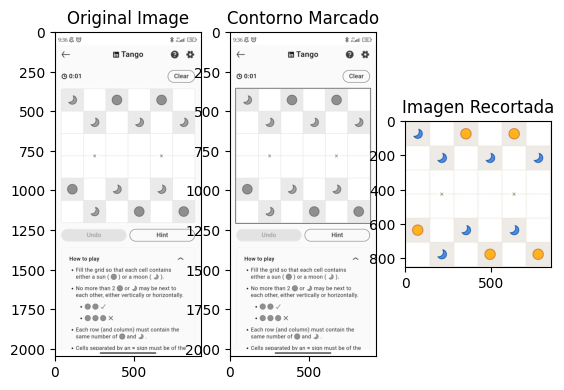

In [79]:
contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_CCOMP , cv2.CHAIN_APPROX_NONE) 
#image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
marked = np.copy(image)
cropped = np.copy(image_og)
if len(contours) != 0:
    # Encontrar el mayor contorno (c) por el area
    c = max(contours, key = cv2.contourArea)
    #Extraer ese contorno, no es el que queremos
    contours = filter(lambda contour: contour.shape != c.shape, contours)
    print(contours)
    c = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)

    # draw the biggest contour (c) in green
    cv2.rectangle(marked,(x,y),(x+w,y+h),(0,255,0),2)
    cropped = cropped[y:(y+h), x:(x+w)]
    
# show the images
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(132)
plt.imshow(marked, cmap='gray')
plt.title('Contorno Marcado')

plt.subplot(133)
plt.imshow(cropped)
plt.title('Imagen Recortada')
#cv2.imwrite(images_path + "cropped.jpeg", cropped)
print(cropped.shape)

In [80]:
def eliminarBordes(image):
    #Dibujar un rectangulo en todos los lados menos las localizaciones de las posibles X o =
    #y de 0-50, x de 0 a 10
    #y de 90-140 x de 0 a 10
    #y de 0 a 10 x de 0 a 50
    #y de 0 a 10 x de 90 a 140
    #y de 0 a 50 x de 130 a 140
    #y de 90 a 140 x de 130 a 140
    #y de 130 a 140 x de 0 a 50
    #y de 130 a 140 x de 90 a 140
    coord1 = (0,10)
    coord2 = (0,50)
    coord3 = (130,140)
    coord4 = (90,140)
    inicio1 = (0,0)
    fin1 = (10,55)
    #(x,y), empezando por la izquierda
    inicios=[(0,0),  (0,0),  (0,85),  (85,0),  (130,85), (85,130), (0,130),(130,0)]
    finales=[(10,55),(55,10),(10,140),(140,10),(140,140),(140,140),(55,140),(140,55)]
    for i in range(0,8):
        image = cv2.rectangle(image,inicios[i],finales[i],(255,255,255),-1)
    

In [81]:
def getCuadrados(image):
    height, width, _ = image.shape
    print(height, width)
    
    cuadrados = []

    for i in range (0, 6):
        
        fila = []
        
        for j in range (0, 6):
            l = int((i*(width/6)) + 1)
            r = int((i+1)*(width/6))
            t = int((j*(height/6)) + 1)
            b = int((j+1)*(height/6))

            cuadrado = image[t:b,l:r] 
            #eliminarBordes(cuadrado)
            cuadrado = cv2.cvtColor(cuadrado, cv2.COLOR_BGR2RGB)
            cv2.imwrite(images_path + "tiles/" + str(i) + str(j) + ".jpeg", cuadrado )
            #fila.append([cuadrado, tileClass(tile)])
            fila.append(cuadrado)
            
        cuadrados.append(fila)
            
    return cuadrados

In [82]:
cuadrados = getCuadrados(cropped)

852 852


TypeError: Image data of dtype object cannot be converted to float

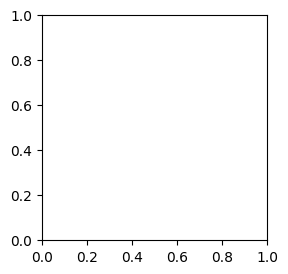

In [77]:
barraH = cv2.imread(images_path + "/tiles/barraH.jpeg", cv2.IMREAD_GRAYSCALE)
barraV = cv2.imread(images_path + "/tiles/barraV.jpeg",cv2.IMREAD_GRAYSCALE)
plt.subplot(121)
plt.imshow(barraH,cmap='gray')
plt.subplot(122)
plt.imshow(barraV,cmap='gray')
plt.show()

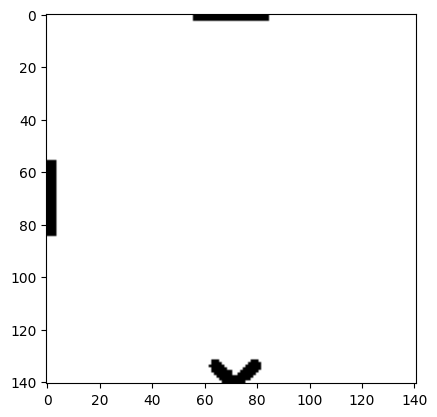

In [44]:
c = cuadrados[1][2]
c = cv2.cvtColor(c, cv2.COLOR_BGR2GRAY)
r, ct = cv2.threshold(c,240,255,cv2.THRESH_BINARY) #Binarización
plt.imshow(ct,cmap='gray')
plt.show()

Text(0.5, 1.0, 'Original image')

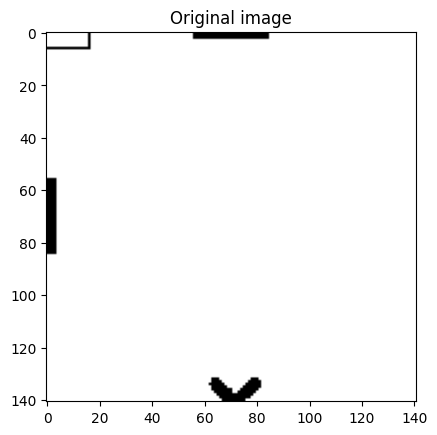

In [46]:
nccH = cv2.matchTemplate(ct, barraV, cv2.TM_CCORR_NORMED)
[max_yH, max_xH] = np.where(nccH == np.amax(nccH))
image_draw = np.copy(ct)
cv2.rectangle(image_draw,(max_xH[0]-15,max_yH[0]-5),(max_xH[0]+16,max_yH[0]+6),0,1)
# Show the original image
plt.imshow(image_draw, cmap = 'gray')
plt.title('Original image')
